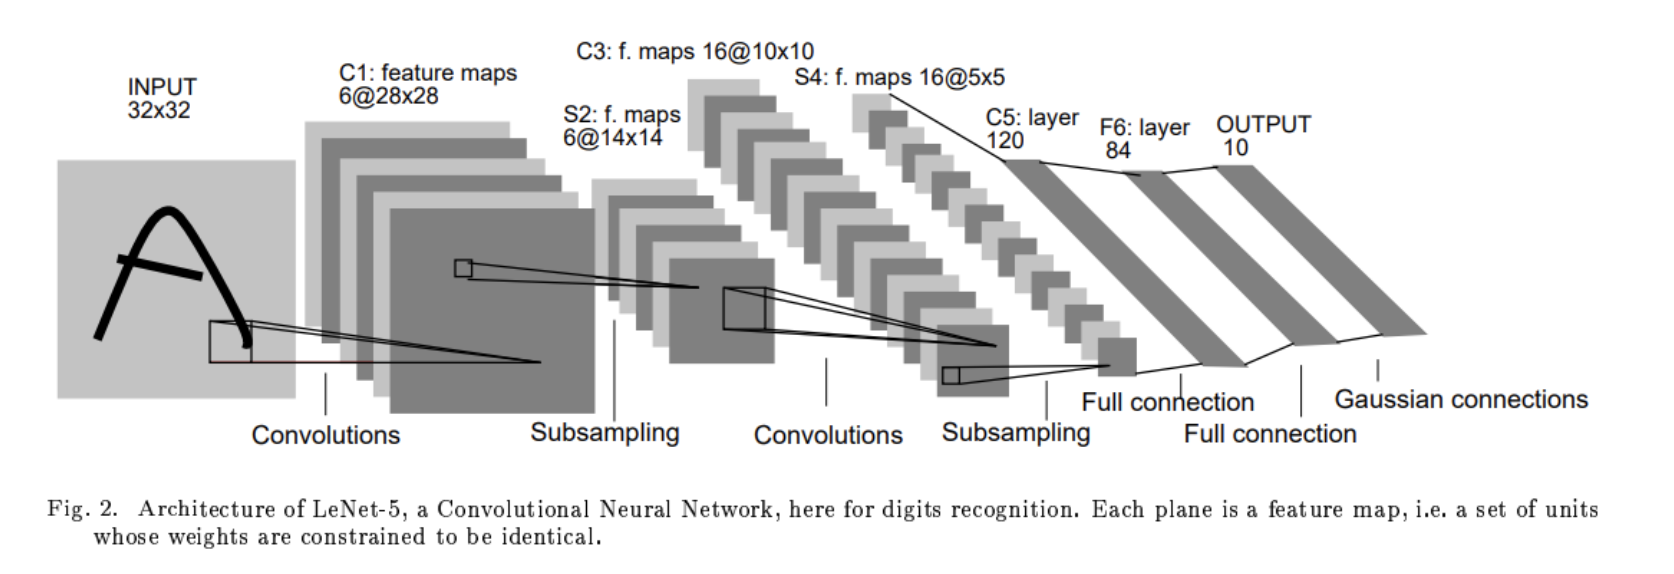

- **Reference**
    - https://www.researchgate.net/publication/344128059_Application_of_a_new_one-dimensional_deep_convolutional_neural_network_for_intelligent_fault_diagnosis_of_rolling_bearings/figures?lo=1&utm_source=google&utm_medium=organic
    - https://astonishing-antlion-13b.notion.site/A-Review-of-Convolutional-Neural-Networks-its-Variants-and-Applications-10fe61796c4280a586b5d2559e2f51a2
    - http://vision.stanford.edu/cs598_spring07/papers/Lecun98.pdf

위 figure은 Yann LeCun 등이 저술한 **\<Gradient Based Learning Applied to Document Recognition\>** 논문에서 나온 LeNet-5 architecture structure이다. 위 figure를 보고 scratch부터 LeNet을 구현해보자.

저자는 여기서 character recognition, 즉 손으로 작성한 특정 글자를 제대로 인식하는 모델을 구현하기 위해 convolution layer를 단계적으로 배치하였다. LeNet의 architecture은 아래와 같이 구성되어 있다.

- **architecture**
    - 입력 → Conv 5 * 5
    - → stride 2인 subsampling을 2번 반복
        - **subsampling == pooling**
    - → Flatten (120 * 1 * 1)
    - → 2개의 Dense layer

In [1]:
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit
from scipy.stats import skew
import os
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import numpy as np
import scipy
from tqdm import tqdm

2024-10-12 12:41:13.238646: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# cnn model vary kernel size
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from matplotlib import pyplot
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from keras.utils import to_categorical

import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Reshape, LSTM, Conv1D, MaxPooling1D
from tensorflow.keras.layers import TimeDistributed, Conv1D, MaxPooling1D


---

In [3]:
# data load

df = pd.read_csv("../../data/PAMAP/PAMAP_features.csv")
df

Unnamed: 0  sub_id  activity_id act_level     hr_mean  hr_mean_normal  \
0            3006       2           17     light   87.000000        1.175676   
1            3497       2            4  moderate  124.605469        1.683858   
2           14495       7            5  vigorous  113.493430        1.891557   
3           13278       7           17     light   82.513672        1.375228   
4           14969       8            3     light   73.000000        1.106061   
...           ...     ...          ...       ...         ...             ...   
11768       10708       6            2     light   82.582031        1.376367   
11769        4870       3            2     light   76.998047        1.132324   
11770       11822       6            4  moderate   93.445312        1.557422   
11771        3866       2            7  moderate  129.160156        1.745408   
11772        3450       2           13  moderate  142.234375        1.922086   

         hr_std  hr_std_normal  hand_tmp_mean  hand_tmp_std  ...  \
0      0.000000   7.105427e-15      34.375000      0.000000  ...   
1      0.927920   1.253946e-02      31.875000      0.000000  ...   
2      2.315888   3.859813e-02      32.500000      0.000000  ...   
3      0.492657   8.210948e-03      33.812500      0.000000  ...   
4      0.000000   7.327472e-15      34.437500      0.000000  ...   
...         ...            ...            ...           ...  ...   
11768  0.930285   1.550475e-02      33.525635      0.030741  ...   
11769  0.806906   1.186626e-02      32.083130      0.029390  ...   
11770  0.493415   8.223580e-03      31.750000      0.000000  ...   
11771  0.361877   4.890232e-03      30.465576      0.031088  ...   
11772  1.714464   2.316843e-02      32.173340      0.026163  ...   

       ankle_acc_xz_cor  hand_gyr_xy_cor  hand_gyr_yz_cor  hand_gyr_xz_cor  \
0              0.233251        -0.472662         0.335516        -0.377507   
1             -0.119772        -0.287380        -0.230390        -0.491314   
2              0.025673        -0.265566         0.824691        -0.121345   
3              0.724061        -0.196728         0.315984        -0.380337   
4             -0.001651        -0.060776         0.165672         0.311760   
...                 ...              ...              ...              ...   
11768          0.193950        -0.354026         0.175876        -0.172933   
11769          0.135629         0.056979         0.008235         0.001093   
11770         -0.404942         0.520845        -0.951838        -0.561901   
11771         -0.136336        -0.147614        -0.344375        -0.329746   
11772          0.200755        -0.081262         0.130816        -0.278256   

       chest_gyr_xy_cor  chest_gyr_yz_cor  chest_gyr_xz_cor  ankle_gyr_xy_cor  \
0             -0.290138         -0.779952          0.071855         -0.305959   
1              0.011124         -0.799319         -0.135736         -0.653133   
2             -0.004923         -0.317761         -0.202148         -0.660278   
3              0.284190         -0.109078         -0.071734         -0.177813   
4             -0.272620         -0.014943         -0.191610         -0.261158   
...                 ...               ...               ...               ...   
11768          0.184131         -0.274344         -0.485489         -0.100010   
11769         -0.203294         -0.097797         -0.273316         -0.009717   
11770         -0.169119          0.299434         -0.100683         -0.555866   
11771         -0.024487         -0.536806         -0.161019         -0.752563   
11772         -0.254757         -0.723943         -0.039044         -0.016410   

       ankle_gyr_yz_cor  ankle_gyr_xz_cor  
0             -0.003001         -0.638866  
1             -0.654575          0.391363  
2             -0.528138          0.402147  
3              0.237828         -0.729771  
4              0.066954          0.057685  
...                 ...               ...  
11768      

In [4]:
# 각 feature의 이름
# https://archive.ics.uci.edu/ml/machine-learning-databases/00231/readme.pdf

features_name = {0: 'transient', 1:'lying', 2:'sitting', 3:'standing',
              4:'walking', 5:'running', 6:'cycling', 7:'Nordic walking',
              9:'watching TV', 10:'computer work', 11:'car driving',
              12:'ascending stairs', 13:'descending stairs', 16:'vacuum cleaning',
              17:'ironing', 18:'folding laundry', 19:'house cleaning',
              20:'playing soccer', 24:'rope jumping'}

print (features_name)
print ()
df.info()

{0: 'transient', 1: 'lying', 2: 'sitting', 3: 'standing', 4: 'walking', 5: 'running', 6: 'cycling', 7: 'Nordic walking', 9: 'watching TV', 10: 'computer work', 11: 'car driving', 12: 'ascending stairs', 13: 'descending stairs', 16: 'vacuum cleaning', 17: 'ironing', 18: 'folding laundry', 19: 'house cleaning', 20: 'playing soccer', 24: 'rope jumping'}

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11773 entries, 0 to 11772
Data columns (total 68 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        11773 non-null  int64  
 1   sub_id            11773 non-null  int64  
 2   activity_id       11773 non-null  int64  
 3   act_level         11773 non-null  object 
 4   hr_mean           11773 non-null  float64
 5   hr_mean_normal    11773 non-null  float64
 6   hr_std            11773 non-null  float64
 7   hr_std_normal     11773 non-null  float64
 8   hand_tmp_mean     11773 non-null  float64
 9   hand_tmp_std   

In [5]:
# 결측치 제거

print (df.isnull().sum())

df = df.dropna()

print (df.isnull().sum())

Unnamed: 0          0
sub_id              0
activity_id         0
act_level           0
hr_mean             0
                   ..
chest_gyr_yz_cor    0
chest_gyr_xz_cor    0
ankle_gyr_xy_cor    0
ankle_gyr_yz_cor    0
ankle_gyr_xz_cor    0
Length: 68, dtype: int64
Unnamed: 0          0
sub_id              0
activity_id         0
act_level           0
hr_mean             0
                   ..
chest_gyr_yz_cor    0
chest_gyr_xz_cor    0
ankle_gyr_xy_cor    0
ankle_gyr_yz_cor    0
ankle_gyr_xz_cor    0
Length: 68, dtype: int64


In [6]:
# label encoding

from sklearn.preprocessing import LabelEncoder
LE = LabelEncoder()
df['activity_id'] = LE.fit_transform(df['activity_id'])
df['act_level'] = LE.fit_transform(df['act_level'])

df

Unnamed: 0  sub_id  activity_id  act_level     hr_mean  hr_mean_normal  \
0            3006       2           10          0   87.000000        1.175676   
1            3497       2            3          1  124.605469        1.683858   
2           14495       7            4          2  113.493430        1.891557   
3           13278       7           10          0   82.513672        1.375228   
4           14969       8            2          0   73.000000        1.106061   
...           ...     ...          ...        ...         ...             ...   
11768       10708       6            1          0   82.582031        1.376367   
11769        4870       3            1          0   76.998047        1.132324   
11770       11822       6            3          1   93.445312        1.557422   
11771        3866       2            6          1  129.160156        1.745408   
11772        3450       2            8          1  142.234375        1.922086   

         hr_std  hr_std_normal  hand_tmp_mean  hand_tmp_std  ...  \
0      0.000000   7.105427e-15      34.375000      0.000000  ...   
1      0.927920   1.253946e-02      31.875000      0.000000  ...   
2      2.315888   3.859813e-02      32.500000      0.000000  ...   
3      0.492657   8.210948e-03      33.812500      0.000000  ...   
4      0.000000   7.327472e-15      34.437500      0.000000  ...   
...         ...            ...            ...           ...  ...   
11768  0.930285   1.550475e-02      33.525635      0.030741  ...   
11769  0.806906   1.186626e-02      32.083130      0.029390  ...   
11770  0.493415   8.223580e-03      31.750000      0.000000  ...   
11771  0.361877   4.890232e-03      30.465576      0.031088  ...   
11772  1.714464   2.316843e-02      32.173340      0.026163  ...   

       ankle_acc_xz_cor  hand_gyr_xy_cor  hand_gyr_yz_cor  hand_gyr_xz_cor  \
0              0.233251        -0.472662         0.335516        -0.377507   
1             -0.119772        -0.287380        -0.230390        -0.491314   
2              0.025673        -0.265566         0.824691        -0.121345   
3              0.724061        -0.196728         0.315984        -0.380337   
4             -0.001651        -0.060776         0.165672         0.311760   
...                 ...              ...              ...              ...   
11768          0.193950        -0.354026         0.175876        -0.172933   
11769          0.135629         0.056979         0.008235         0.001093   
11770         -0.404942         0.520845        -0.951838        -0.561901   
11771         -0.136336        -0.147614        -0.344375        -0.329746   
11772          0.200755        -0.081262         0.130816        -0.278256   

       chest_gyr_xy_cor  chest_gyr_yz_cor  chest_gyr_xz_cor  ankle_gyr_xy_cor  \
0             -0.290138         -0.779952          0.071855         -0.305959   
1              0.011124         -0.799319         -0.135736         -0.653133   
2             -0.004923         -0.317761         -0.202148         -0.660278   
3              0.284190         -0.109078         -0.071734         -0.177813   
4             -0.272620         -0.014943         -0.191610         -0.261158   
...                 ...               ...               ...               ...   
11768          0.184131         -0.274344         -0.485489         -0.100010   
11769         -0.203294         -0.097797         -0.273316         -0.009717   
11770         -0.169119          0.299434         -0.100683         -0.555866   
11771         -0.024487         -0.536806         -0.161019         -0.752563   
11772         -0.254757         -0.723943         -0.039044         -0.016410   

       ankle_gyr_yz_cor  ankle_gyr_xz_cor  
0             -0.003001         -0.638866  
1             -0.654575          0.391363  
2             -0.528138          0.402147  
3              0.237828         -0.729771  
4              0.066954          0.057685  
...                 ...               ...  

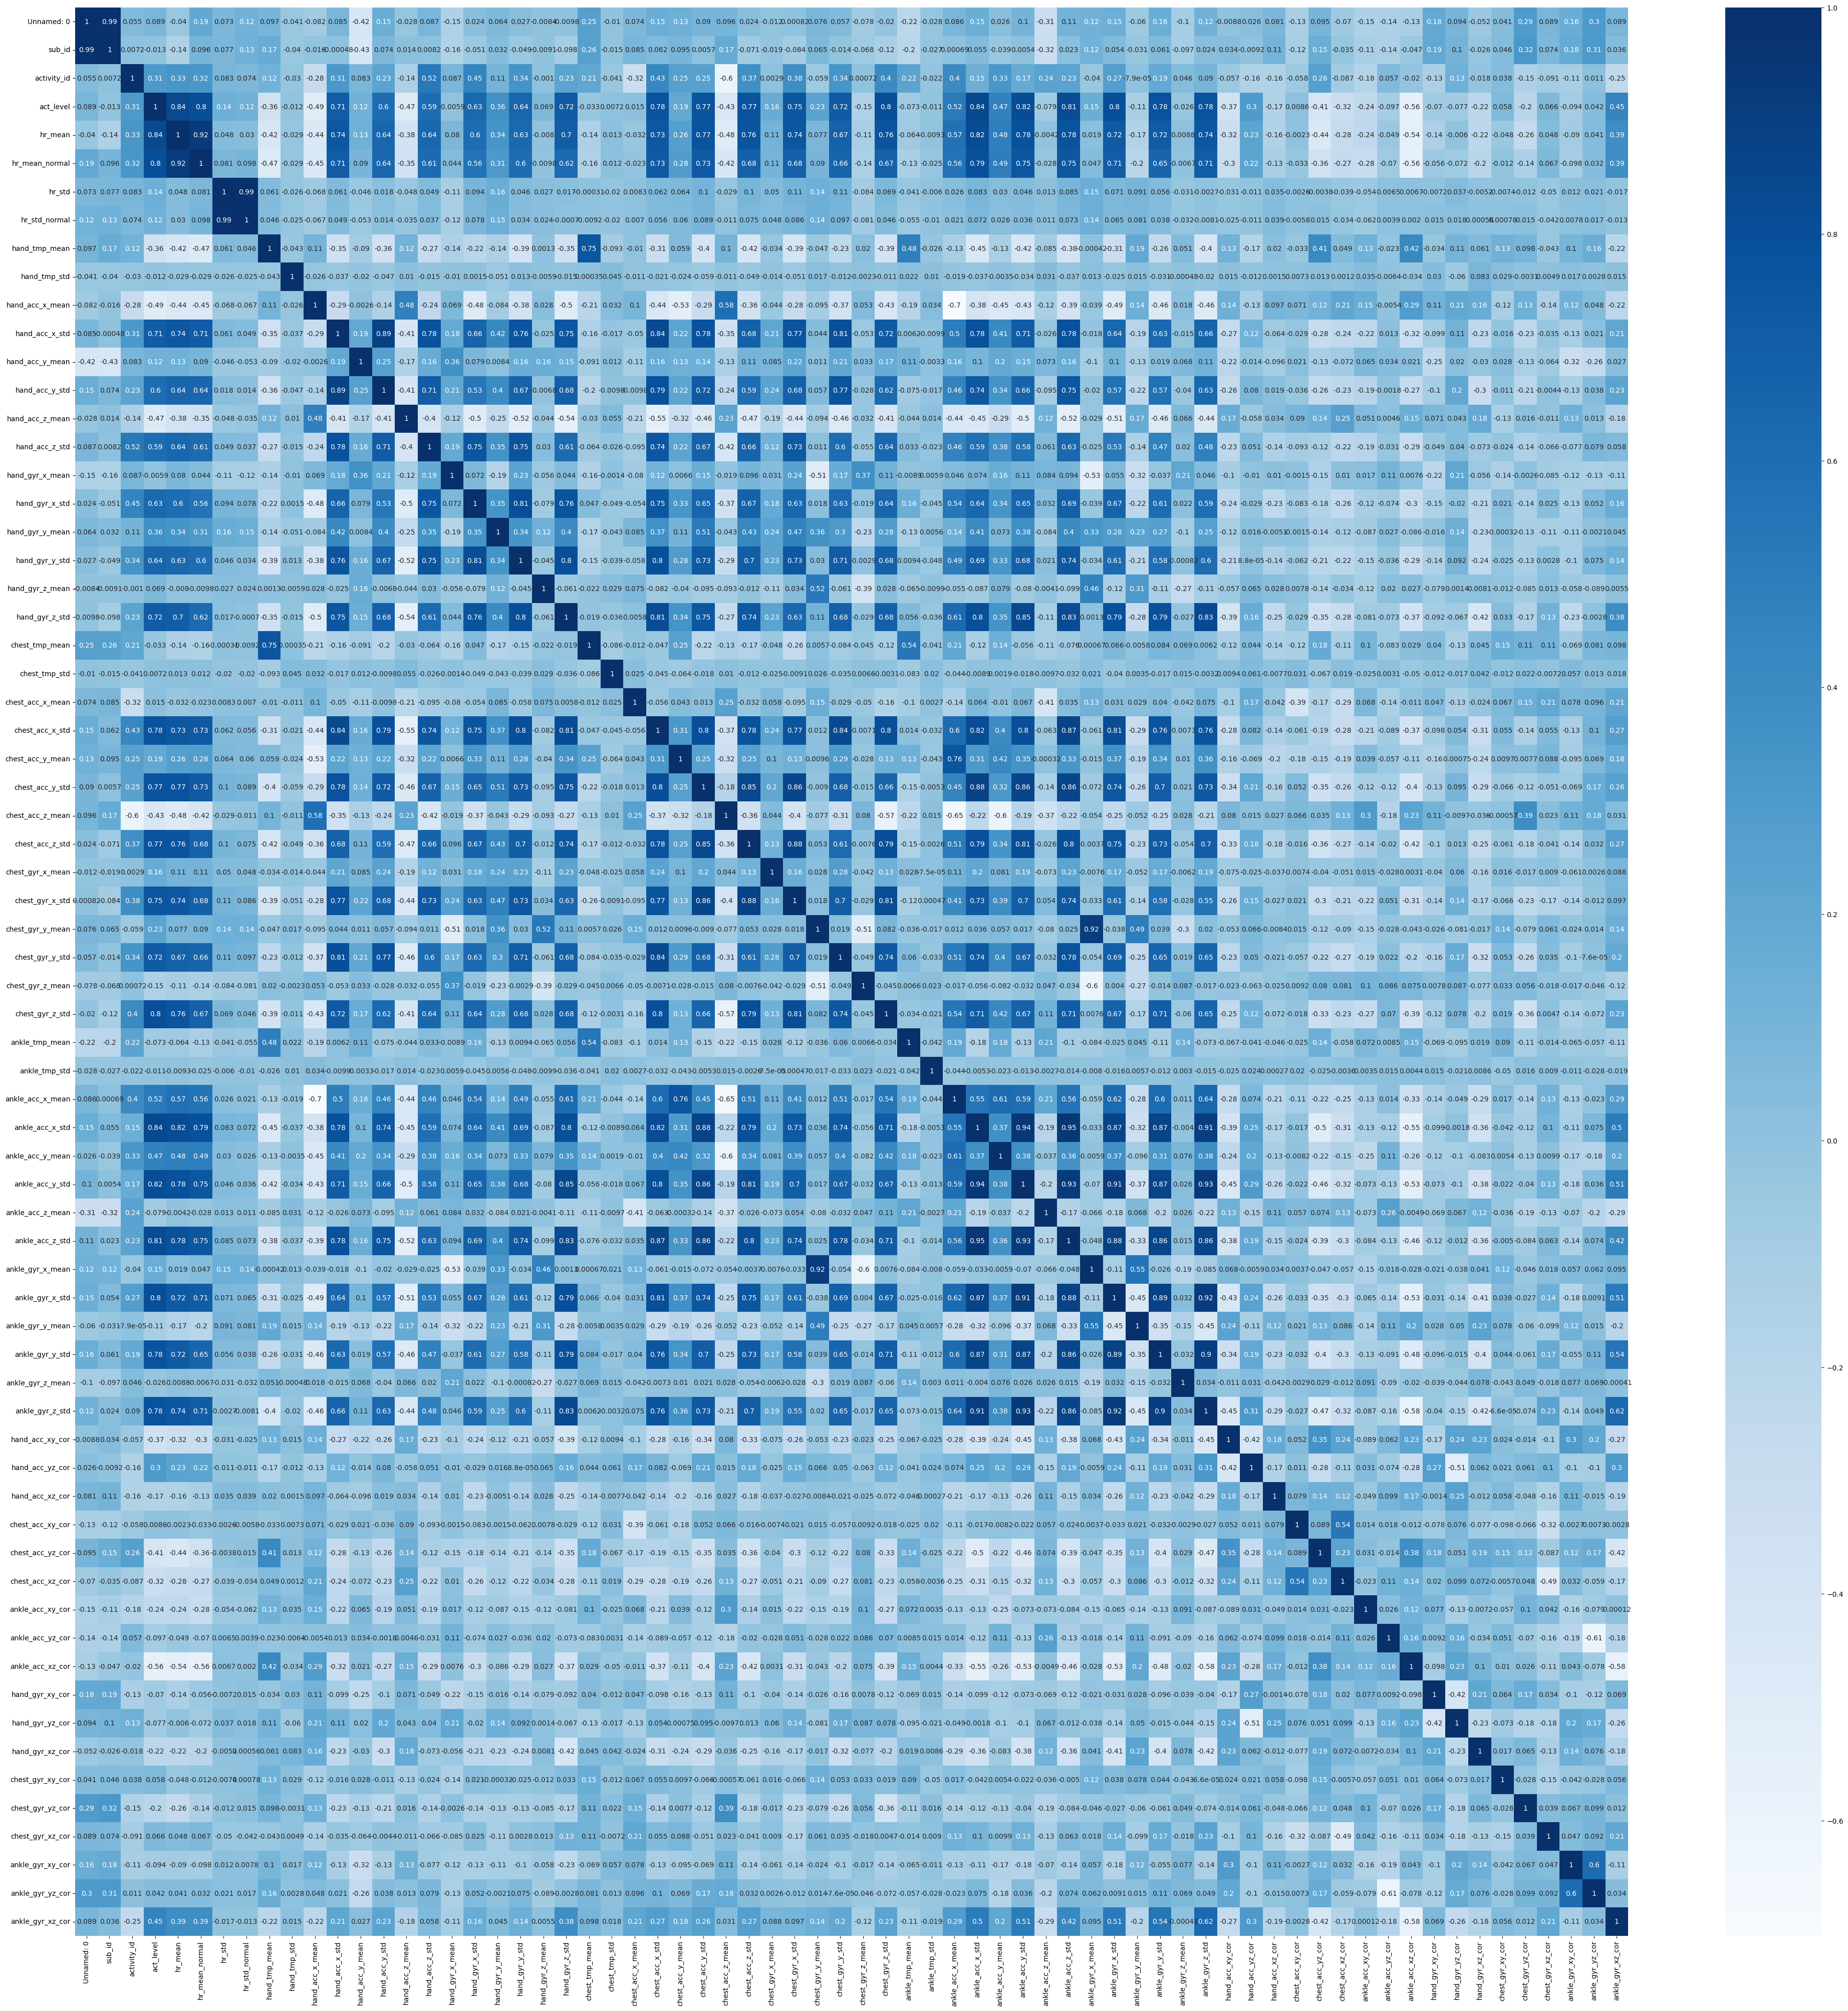

In [7]:
# heatmap visulization

plt.figure(figsize=(50, 50))

df_corr = df.corr()
sns.heatmap(df_corr, annot=True, cbar=True,
           cmap='Blues', annot_kws={"size": 10})
plt.show()

In [8]:
# 필요없는 열 제거

df = df.drop(['Unnamed: 0',
              'sub_id',
              'act_level',
              'hr_mean',
              'hr_mean_normal',
              'hr_std',
              'hr_std_normal'], axis = 1)

# PAMAP_input = df.drop(['activity_id'], axis = 1) 
# PAMAP_target = df['activity_id'] # activity_id를 예측하는 문제

# print (PAMAP_input.shape, PAMAP_target.shape)

In [9]:
# 상관관계가 낮은 8개 열 제거 (복잡성 줄이기 위해)

correlation_matrix = df.corr()
mean_corr = correlation_matrix.abs().mean().sort_values()
low_corr_columns = mean_corr.index[:8]
df = df.drop(low_corr_columns, axis=1)

df.shape

(11773, 53)

In [10]:
# target에 포함된 요소들 확인하기

print (df['activity_id'].unique())


'''
    label이 0-based가 아니기 때문에 0-based로 바꾸어야 할 듯 하다.
    (labelencoding)
'''

[10  3  4  2  5  1  6  9  7  0  8 11]


'\n    label이 0-based가 아니기 때문에 0-based로 바꾸어야 할 듯 하다.\n    (labelencoding)\n'

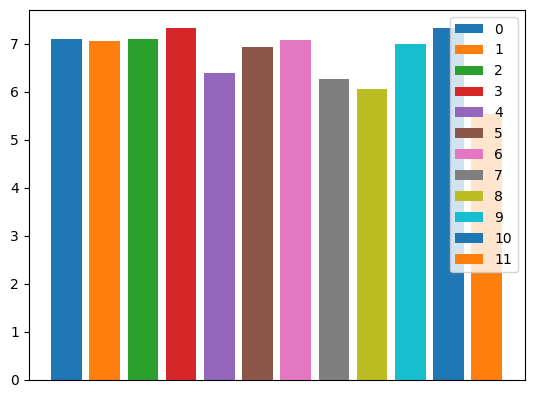

activity_id
10    1539
3     1525
2     1220
0     1203
6     1196
1     1162
9     1099
5     1035
4      593
7      522
8      428
11     251
Name: count, dtype: int64


In [11]:
# activity_id의 countplot, value_count

import math

target = np.unique(df['activity_id'])

# 시각화 진행

width = 1
for compo in target : 
    plt.bar(width, math.log(len(df[df['activity_id'] == compo])), 
            label=compo)
    width += 1
    
plt.xticks([], [])

plt.legend()
plt.show()

print (df['activity_id'].value_counts())

In [12]:

'''
    oversampling과 undersampling을 함수로 구현한다. 
'''
    
def sampling(df, target_col, max_size) :
    # 결과를 저장할 리스트 
    dfs = []
    
    for label in df[target_col].unique() :
        class_df = df[df[target_col] == label]
        
        if len(class_df) < max_size :
            # 샘플 수가 max_size보다 적으면 데이터를 복제하여 max_size로 만듦
            sampled_df = class_df.sample(max_size, replace=True, random_state=42)
        else :
            # 샘플 수가 max_size보다 많으면 앞부분부터 max_size만큼 선택함
            sampled_df = class_df.head(max_size)
        
        # 리스트에 추가
        dfs.append(sampled_df)
    
    df_resampled = pd.concat(dfs).reset_index(drop=True)
    
    return df_resampled

df_resampled = sampling(df, 'activity_id', max_size=5000)
print (df_resampled['activity_id'].value_counts())

activity_id
10    5000
3     5000
4     5000
2     5000
5     5000
1     5000
6     5000
9     5000
7     5000
0     5000
8     5000
11    5000
Name: count, dtype: int64


In [13]:
# Z-score normalization을 진행한다.

from sklearn.preprocessing import StandardScaler

X = df_resampled[[feature_name for feature_name in df_resampled.columns if feature_name != 'activity_id']]
y = df_resampled['activity_id']

SS = StandardScaler()
X = SS.fit_transform(X)

scaled_df = pd.DataFrame(data=X, 
                        columns = [feature_name for feature_name in df.columns if feature_name != 'activity_id'])
scaled_df['activity_id'] = y

scaled_df 

hand_tmp_mean  hand_acc_x_mean  hand_acc_x_std  hand_acc_y_mean  \
0           0.527898        -0.044816       -0.762108         0.765312   
1           0.940570         0.969473       -0.251097         0.644073   
2           0.777537        -0.239336       -0.569838        -0.270210   
3           0.153440         0.147068       -0.235050         0.731867   
4           0.559103         0.095370       -0.799334        -0.637938   
...              ...              ...             ...              ...   
59995      -1.157164        -0.186185        1.595995         1.033103   
59996       0.654424        -0.013637        1.293858         0.868660   
59997      -1.157164        -0.373120        0.973337         0.866579   
59998      -1.157164         0.022779        1.373668         1.110390   
59999      -3.715962         0.763889        0.270761         1.220101   

       hand_acc_y_std  hand_acc_z_mean  hand_acc_z_std  hand_gyr_x_mean  \
0           -0.482107        -0.127809       -0.314787        -0.122158   
1           -0.333091         0.920250       -0.255443         0.040868   
2           -0.148454         1.124756       -0.243076        -0.199861   
3           -0.240622        -0.025017        0.333309        -0.158172   
4           -0.398449         1.607094       -0.818488        -0.020964   
...               ...              ...             ...              ...   
59995        0.422174        -0.618533        1.417111         1.149277   
59996        1.220307        -0.881265        2.368193         0.507456   
59997        0.418600        -0.296487        1.566516         1.540726   
59998        0.472420        -0.472215        1.321416         2.095630   
59999        1.403727        -1.282617        1.885651         1.190166   

       hand_gyr_x_std  hand_gyr_y_mean  ...  ankle_acc_xz_cor  \
0           -0.189911        -0.138028  ...          0.745353   
1           -0.094257        -0.346445  ...          1.234475   
2            0.204090        -0.060375  ...          1.192204   
3            0.555950        -0.674327  ...          1.181053   
4           -0.872833        -0.293721  ...          1.409421   
...               ...              ...  ...               ...   
59995        0.895944         0.527583  ...         -1.001085   
59996        2.254324         0.982301  ...         -1.219991   
59997        0.776100         1.679993  ...         -0.784365   
59998        0.855658         1.263174  ...         -1.130238   
59999        0.689969        -0.470309  ...         -1.923601   

       hand_gyr_xy_cor  hand_gyr_yz_cor  hand_gyr_xz_cor  chest_gyr_yz_cor  \
0            -0.824033        -0.222055         1.997304          0.117835   
1            -0.313027         0.282719         0.485668         -1.906989   
2            -1.923821         1.101581        -1.193029         -0.923415   
3            -1.024990         1.271741         0.629128         -0.729675   
4            -0.919179         1.011423        -1.602723         -0.352294   
...                ...              ...              ...               ...   
59995        -0.886228         0.889203         0.742467          0.459232   
59996        -2.112127         0.448552        -0.585923          0.748718   
59997        -1.281992         0.251409         0.635452          0.525027   
59998        -0.947146         0.355464         1.106940          0.407651   
59999        -0.665361         0.948307        -0.943239          0.759458   

       chest_gyr_xz_cor  ankle_gyr_xy_cor  ankle_gyr_yz_cor  ankle_gyr_xz_cor  \
0              0.022973         -0.180623         -0.512241          0.422379   
1              2.781428         -0.272818          0.470489         -0.559575   
2             -0.725131          0.560882         -0.556085         -1.607795   
3             -1.816482         -1.230121         -0.112650         -0.930112   
4              0.819493         -0.338989         -0.002148         -1.797672   
...          

In [14]:
# input, target split

input_PAMAP = df_resampled.drop('activity_id', axis=1)
target_PAMAP = df_resampled['activity_id']

input_PAMAP.shape, target_PAMAP.shape

((60000, 52), (60000,))

In [15]:
# train, test split

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(input_PAMAP,
                                                    target_PAMAP,
                                                    stratify=target_PAMAP,
                                                    test_size = 0.2, shuffle=True) 

# X_train, X_val, y_train, y_val = train_test_split(X_train,
#                                                     y_train,
#                                                     stratify=y_train,
#                                                     test_size = 0.2, shuffle=True) 

X_train.shape, X_test.shape

((48000, 52), (12000, 52))

In [16]:
# train, test reshape
# DataFrame을 NumPy 배열로 변환한 후 reshape
X_train = X_train.values.reshape(-1, 13, 4)
X_test = X_test.values.reshape(-1, 13, 4)

In [17]:
'''
    순환 데이터를 구성하기 위하여 split_sequences를 사용하였다.
    이때, 각 window마다 class의 빈도 수를 측정하여 가장 많은 빈도수를 가진 class가 target이 되는 방식을 취하였다.
'''

# from collections import Counter
# import numpy as np

# def split_sequences_freq(sequences, n_steps):
#     X, y = list(), list()
    
#     # Check if sequences is a DataFrame, convert if necessary
#     if not isinstance(sequences, pd.DataFrame):
#         sequences = pd.DataFrame(sequences)

#     for i in range(len(sequences)):
#         end_ix = i + n_steps

#         if end_ix > len(sequences):
#             break

#         seq_x = sequences.iloc[i:end_ix, :-1].values
#         seq_y = sequences.iloc[i:end_ix, -1].values   
        
#         # Find the most frequent class in seq_y
#         most_frequent_class = Counter(seq_y).most_common(1)[0][0]
        
#         X.append(seq_x)
#         y.append(int(most_frequent_class))

#     return np.array(X), np.array(y)

'\n    순환 데이터를 구성하기 위하여 split_sequences를 사용하였다.\n    이때, 각 window마다 class의 빈도 수를 측정하여 가장 많은 빈도수를 가진 class가 target이 되는 방식을 취하였다.\n'

In [18]:
# 순환 데이터 구성

# train_set = np.c_[X_train, y_train]
# test_set = np.c_[X_test, y_test]
# # val_set = np.c_[X_val, y_val]

# X_train_seq, y_train_seq = split_sequences_freq(train_set, 100) # 100개씩 묶기
# print (X_train_seq)
# print (y_train_seq)

# print ("train : ", X_train_seq.shape, y_train_seq.shape)

# X_test_seq, y_test_seq = split_sequences_freq(test_set, 100) # 100개씩 묶기
# print (X_test_seq)
# print (y_test_seq)

# print ("test : ", X_test_seq.shape, y_test_seq.shape)

# # X_val_seq, y_val_seq = split_sequences_freq(val_set, 20) # 20개씩 묶기
# # print (X_val_seq)
# # print (y_val_seq)

# # print ("val : ", X_val_seq.shape, y_val_seq.shape)

In [19]:
# 실제로 어떻게 구성되었는지 X_train_seq와 y_train_seq의 앞쪽 5개의 component만 출력

# print (np.isnan(y_train_seq).sum())

# for idx in range (5) :
#     print (f"X_train_seq[{idx}] : ", X_train_seq[idx][:5])
#     print (f"y_train_seq[{idx}] : ", y_train_seq[idx])
    
#     if idx == 0 : 
#         prev = X_train_seq[idx]
#         print()
#         continue

#     if (prev[1:] == X_train_seq[idx][:-1]).all() : 
#         '''
#             step 1씩 이동했으니깐, 이전 X_train_seq 원소의 2번째 record ~ 마지막번째 record와
#             현재 X_train_seq 원소의 첫번째 record ~ 마지막-1번째 record는 같을 수밖에 없습니다.
#         '''
         
#         print ("window가 step 1씩 이동하면서 순환 데이터를 만듦")
    
#     prev = X_train_seq[idx]
#     print()

In [20]:
# one-hot encoding 

from tensorflow.keras.utils import to_categorical

y_train_encoded = to_categorical(y_train)
y_test_encoded = to_categorical(y_test)
# y_val_seq_encoded = to_categorical(y_val_seq)

print(y_train[:5])  
print(y_train_encoded[:5]) 

print(y_test[:5])  
print(y_test_encoded[:5])

# print(y_val_seq[:5])  
# print(y_val_seq_encoded[:5])

54768     8
2661     10
437      10
17113     2
31826     6
Name: activity_id, dtype: int64
[[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]
53906     8
39441     9
57653    11
14918     4
36792     9
Name: activity_id, dtype: int64
[[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]


In [21]:
verbose, epochs, batch_size = 1, 100, 32 
# 모든 프로세서 병렬 사용, epoch 100, batch_size 32로 세팅

input_shape = X_train[0].shape
print (input_shape)

(13, 4)


-----

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 11, 2)          │            26 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling1d_2             │ (None, 5, 2)           │             0 │
│ (AveragePooling1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 3, 2)           │            14 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling1d_3             │ (None, 1, 2)           │             0 │
│ (AveragePooling1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 120)            │           360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 84)             │        10,164 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 12)             │         1,020 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,584 (45.25 KB)

 Trainable params: 11,584 (45.25 KB)

 Non-trainable params: 0 (0.00 B)

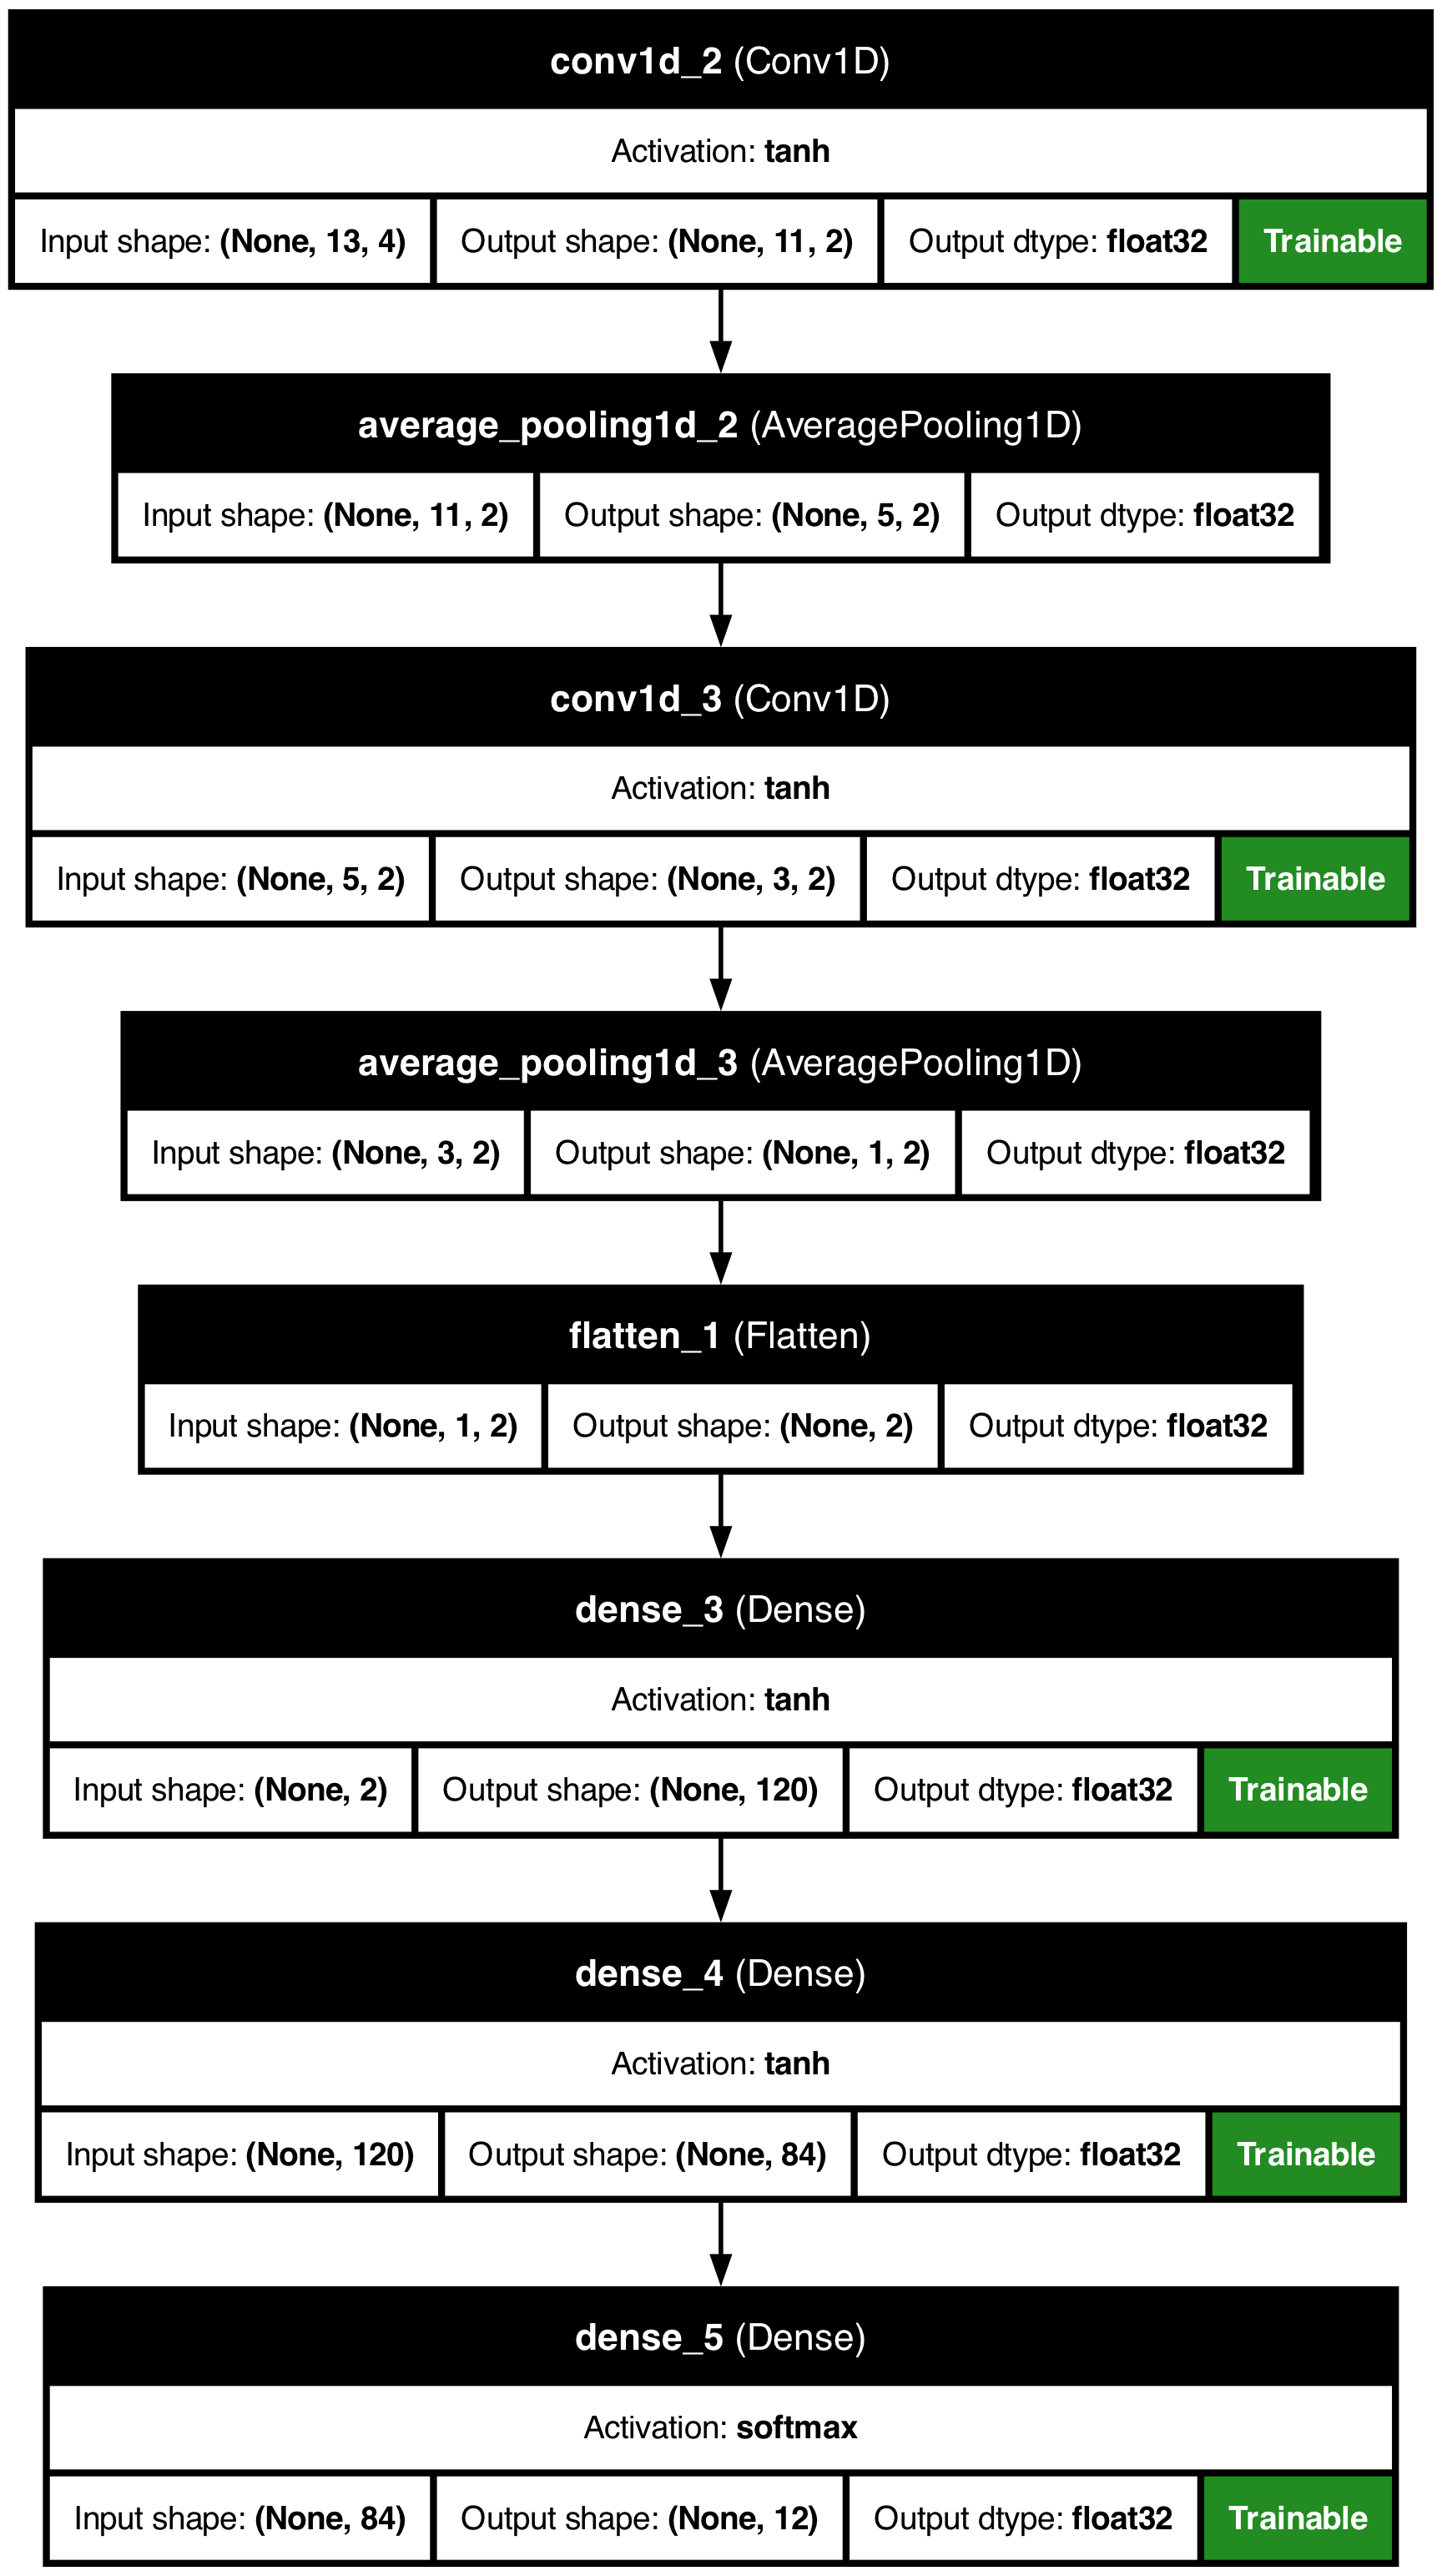

In [25]:
# modeling

import tensorflow as tf

# modeling

'''
    위 LeNet 구조를 보았을 때, 
    convolution+pooling을 2번 반복한 후, Dense layer로 full connection block을 이루고 있다. 아래와 같이 modeling 가능하다.
'''

from keras.utils import plot_model
from keras.models import Sequential
from keras.layers import Conv1D, AvgPool1D, Flatten, Dense, Input

def make_LeNet(input_shape, target_size) :
    model = Sequential()
    model.add(Input(shape=input_shape))  # Input 레이어 추가
    model.add(Conv1D(filters=2, kernel_size=3, strides=1, activation='tanh'))
    model.add(AvgPool1D(pool_size=2, strides=2))
    model.add(Conv1D(filters=2, kernel_size=3, strides=1, activation='tanh'))
    model.add(AvgPool1D(pool_size=2, strides=2))
    model.add(Flatten())
    model.add(Dense(120, activation='tanh'))
    model.add(Dense(84, activation='tanh'))
    model.add(Dense(target_size, activation='softmax'))
    
    return model

LeNet = make_LeNet(input_shape=input_shape,
                  target_size=12)

LeNet.summary()

plot_model(LeNet, 
           show_shapes=True, show_layer_activations=True, 
           show_dtype=True, show_layer_names=True, show_trainable=True)

In [26]:
# compile

optimizer = keras.optimizers.Adam(learning_rate=0.0001)
LeNet.compile (optimizer=optimizer, 
               loss='categorical_crossentropy', 
               metrics=['accuracy'])

In [27]:
# fit

from memory_profiler import profile

@profile # 메모리 오버플로우로 인한 시스템 다운을 막기 위해서
def train_model(model, X, y) :
    early_stopping_cb = keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True)
    
    history = model.fit(X, y, epochs=50, 
                        validation_split=0.2,
                        batch_size=256,
                        callbacks=[early_stopping_cb], 
                        verbose=True, shuffle=True)
    
    return history

history = train_model(LeNet, X_train, y_train_encoded)


ERROR: Could not find file /var/folders/_z/gryfr07n59jgb3wrd062h1ym0000gn/T/ipykernel_7287/3664458649.py
Epoch 1/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.1280 - loss: 2.4651 - val_accuracy: 0.2140 - val_loss: 2.3753
Epoch 2/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.1947 - loss: 2.3252 - val_accuracy: 0.2195 - val_loss: 2.1301
Epoch 3/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.2338 - loss: 2.0614 - val_accuracy: 0.2848 - val_loss: 1.8758
Epoch 4/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.2978 - loss: 1.8309 - val_accuracy: 0.3389 - val_loss: 1.7204
Epoch 5/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.3595 - loss: 1.6888 - val_accuracy: 0.3790 - val_loss: 1.6068
Epoch 6/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.3507 - loss: 1.5805 - val_accuracy: 0.3927 - val_loss: 1.5183
Epoch 7/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.4077 - loss: 1.5011 - val_accuracy: 0.4169 - val_loss:

150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7539 - loss: 0.6431 - val_accuracy: 0.7469 - val_loss: 0.6568


{'accuracy': [0.16374999284744263, 0.19374999403953552, 0.25843751430511475, 0.30841144919395447, 0.37036457657814026, 0.3636458218097687, 0.4186197817325592, 0.46893230080604553, 0.47442707419395447, 0.5231770873069763, 0.553697943687439, 0.5799999833106995, 0.5969791412353516, 0.6063281297683716, 0.6095312237739563, 0.6166666746139526, 0.6154947876930237, 0.6224218606948853, 0.627734363079071, 0.6312500238418579, 0.6352343559265137, 0.6407812237739563, 0.6416926980018616, 0.6473437547683716, 0.65059894323349, 0.6541406512260437, 0.6559895873069763, 0.6583073139190674, 0.6623697876930237, 0.6645833253860474, 0.6657552123069763, 0.667395830154419, 0.6699739694595337, 0.6745572686195374, 0.6771093606948853, 0.6829947829246521, 0.6890104413032532, 0.6939843893051147, 0.6970052123069763, 0.7011197805404663, 0.7039322853088379, 0.7092708349227905, 0.7108854055404663, 0.7156510353088379, 0.7215364575386047, 0.725572943687439, 0.7330729365348816, 0.7408593893051147, 0.7486458420753479, 0.753

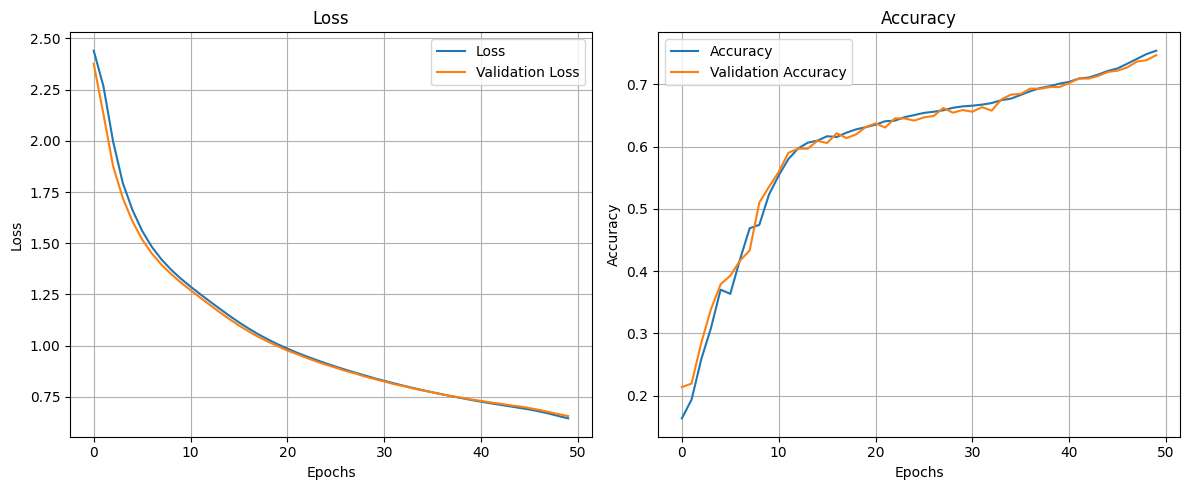

In [28]:
# loss와 validation loss, acc와 validation acc를 시각화하기 위한 메소드

print (history.history)

def draw_history (history) :
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))

    ax[0].plot(history.history['loss'], label='Loss')
    ax[0].plot(history.history['val_loss'], label='Validation Loss')
    ax[0].set_title('Loss')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[0].legend()
    ax[0].grid()

    ax[1].plot(history.history['accuracy'], label='Accuracy')
    ax[1].plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax[1].set_title('Accuracy')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend()
    ax[1].grid()

    plt.tight_layout()
    plt.show()

draw_history(history)

In [29]:
# evaulate

print ("train score : ", LeNet.evaluate(X_train, y_train_encoded))
print ("test score : ", LeNet.evaluate(X_test, y_test_encoded))

eval = LeNet.evaluate(X_test, y_test_encoded)

print(eval)

1500/1500 ━━━━━━━━━━━━━━━━━━━━ 1s 641us/step - accuracy: 0.7541 - loss: 0.6442
train score :  [0.6437259316444397, 0.7544375061988831]
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step - accuracy: 0.7574 - loss: 0.6379
test score :  [0.6467992067337036, 0.7570833563804626]
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 661us/step - accuracy: 0.7574 - loss: 0.6379
[0.6467992067337036, 0.7570833563804626]


375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 628us/step
Confusion Matrix


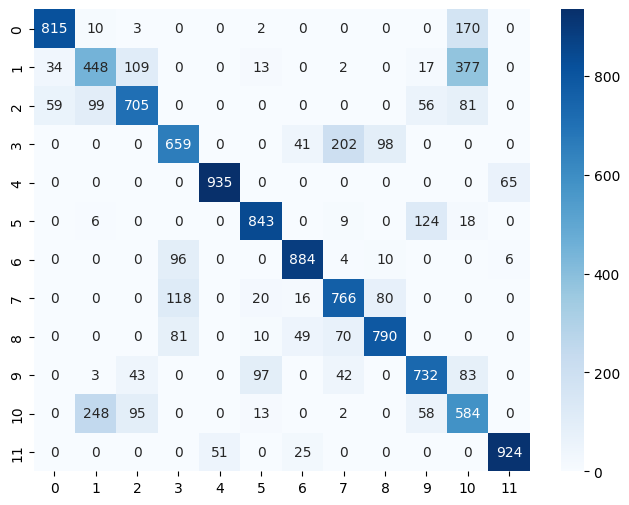

              precision    recall  f1-score   support

           0       0.90      0.81      0.85      1000
           1       0.55      0.45      0.49      1000
           2       0.74      0.70      0.72      1000
           3       0.69      0.66      0.67      1000
           4       0.95      0.94      0.94      1000
           5       0.84      0.84      0.84      1000
           6       0.87      0.88      0.88      1000
           7       0.70      0.77      0.73      1000
           8       0.81      0.79      0.80      1000
           9       0.74      0.73      0.74      1000
          10       0.44      0.58      0.50      1000
          11       0.93      0.92      0.93      1000

    accuracy                           0.76     12000
   macro avg       0.76      0.76      0.76     12000
weighted avg       0.76      0.76      0.76     12000



In [30]:
# confusion matrix, classification report, accuracy

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

y_test_arg = np.argmax(y_test_encoded, axis=1)
Y_pred = np.argmax(LeNet.predict(X_test) ,axis=1)
print ('Confusion Matrix')
cm = confusion_matrix(y_test_arg, Y_pred)

# confusion matrix 시각화
plt.figure(figsize=(8, 6))  # 그래프 크기 조절 (너비 8, 높이 6)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.show()

# classification report
report = classification_report(y_test_arg, Y_pred)
print (report)

In [31]:
# 모델 저장

from tensorflow.keras.models import save_model

def save_trained_model(model, model_name, dataset_name) :
    # 모델 저장 경로 설정
    model_dir = './model'
    os.makedirs(model_dir, exist_ok=True)
    
    # 모델 파일 경로
    model_name = f"{model_name}_{dataset_name}.h5"  # 모델 이름과 데이터셋 이름 조합
    model_path = os.path.join(model_dir, model_name)
    
    # 모델 저장
    save_model(model, model_path)
    print(f'Model saved at {model_path}')

save_trained_model(LeNet, "LeNet", "PAMAP")

Model saved at ./model/LeNet_PAMAP.h5
